<a href="https://colab.research.google.com/github/antoineodier/pytorchSeminar/blob/master/06_RNN_de.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

# Prediction der Fibonacci-Reihe


In [0]:
import torch
import torch.nn as nn  
import torch.nn.functional as F  
import torch.optim as optim  

def fibo(n): 
    assert n > 0
    assert type(n) == int
    if n == 1 or n == 2: 
        return 1 
    return fibo(n-1) + fibo(n-2)

def fibo_sequence(start=1, end=2):
    return [fibo(n) for n in range(start, end+1, 1)]


In [0]:
print(fibo(10))

fibo_seq = fibo_sequence(3, 7)
print(fibo_seq)


55
[2, 3, 5, 8, 13]


In [0]:
# Generieren von Daten
data = [fibo_sequence(8, 16), fibo_sequence(9, 17), fibo_sequence(2, 10), 
        fibo_sequence(4, 12), fibo_sequence(1, 9), fibo_sequence(6, 14)]

data = torch.tensor(data).float()
#print(data)
print(data.size())


torch.Size([6, 9])


In [0]:
data_x = data[:, :-1].t()
print(data_x.size())

target = torch.tensor(data[:, -1]).float()
print(target.size())

torch.Size([8, 6])
torch.Size([6])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [0]:
sequence_length = 8
input_size = 1
hidden_size = 50
batch_size = 6
num_layers = 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=False)
        self.fc = nn.Linear(num_layers*hidden_size, 1)
    
    def forward(self, x):
        # Set initial hidden states 
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device) 
        
        # Forward Pass
        all_hidden, hidden = self.gru(x, h0)  # out: tensor of shape (seq_length, batch_size, hidden_size)
        out = self.fc(hidden)
        
        return out

model = GRU(input_size, hidden_size).to(device)
print(model)

GRU(
  (gru): GRU(1, 50)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [0]:
data_x = data_x.view(sequence_length, batch_size, 1).to(device) # (seq_len, batch_size, encoding_dim)
model(data_x) 

tensor([[[-0.9975],
         [-0.9942],
         [-0.6890],
         [-0.8584],
         [-0.6108],
         [-1.0191]]], device='cuda:0', grad_fn=<AddBackward0>)

In [0]:
learning_rate = 0.005
num_epochs = 15000

criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model(data_x.view(sequence_length, batch_size, 1).to(device))
    loss = criterion(outputs.view(-1), target.view(-1).to(device))
     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    if (epoch+1) % 500 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))    

Epoch [500/15000], Loss: 494581.2812
Epoch [1000/15000], Loss: 402175.2188
Epoch [1500/15000], Loss: 327040.4688
Epoch [2000/15000], Loss: 265498.7500
Epoch [2500/15000], Loss: 212552.5469
Epoch [3000/15000], Loss: 178897.1094
Epoch [3500/15000], Loss: 140680.5625
Epoch [4000/15000], Loss: 129791.8203
Epoch [4500/15000], Loss: 97179.0547
Epoch [5000/15000], Loss: 74107.9844
Epoch [5500/15000], Loss: 57979.1250
Epoch [6000/15000], Loss: 47883.1055
Epoch [6500/15000], Loss: 41854.1445
Epoch [7000/15000], Loss: 38403.8594
Epoch [7500/15000], Loss: 36347.8867
Epoch [8000/15000], Loss: 34921.4727
Epoch [8500/15000], Loss: 33782.2617
Epoch [9000/15000], Loss: 32850.2227
Epoch [9500/15000], Loss: 32128.7969
Epoch [10000/15000], Loss: 31618.1641
Epoch [10500/15000], Loss: 31295.8750
Epoch [11000/15000], Loss: 31120.6777
Epoch [11500/15000], Loss: 31042.5605
Epoch [12000/15000], Loss: 31015.8340
Epoch [12500/15000], Loss: 31009.4004
Epoch [13000/15000], Loss: 31008.4199
Epoch [13500/15000], Los

In [0]:
print(target[2])
model(data_x[:, 2].view(sequence_length, 1, 1).to(device))

tensor(55.)


tensor([[[55.0005]]], device='cuda:0', grad_fn=<AddBackward0>)

In [0]:
test_seq = fibo_sequence(7, 15)
print(test_seq)

test_x = torch.tensor(test_seq[:-1]).float()
print(test_x)

test_y = torch.tensor(test_seq[-1]).float()
print(test_y)

model(test_x.view(sequence_length, 1, 1).to(device))

[13, 21, 34, 55, 89, 144, 233, 377, 610]
tensor([ 13.,  21.,  34.,  55.,  89., 144., 233., 377.])
tensor(610.)


tensor([[[1291.9989]]], device='cuda:0', grad_fn=<AddBackward0>)

In [0]:
test_seq = fibo_sequence(3, 11)
print(test_seq)

test_x = torch.tensor(test_seq[:-1]).float()
print(test_x)

test_y = torch.tensor(test_seq[-1]).float()
print(test_y)

model(test_x.view(sequence_length, 1, 1).to(device))

[2, 3, 5, 8, 13, 21, 34, 55, 89]
tensor([ 2.,  3.,  5.,  8., 13., 21., 34., 55.])
tensor(89.)


tensor([[[16.0077]]], device='cuda:0', grad_fn=<AddBackward0>)

# Übung: FashionMNIST als Klassification einer Sequenz
1. Interpretiere den FashionMNIST Datensatz als sequentiellen Daten: Jeweils bestehend aus einer Sequenz von 28 Reihen mit 28 Features (Spalte). Schreibe dafür ein einfaches Netzwerkmodul aus einem LSTM-Layer, gefolgt von einem Fully-Connected-Layer


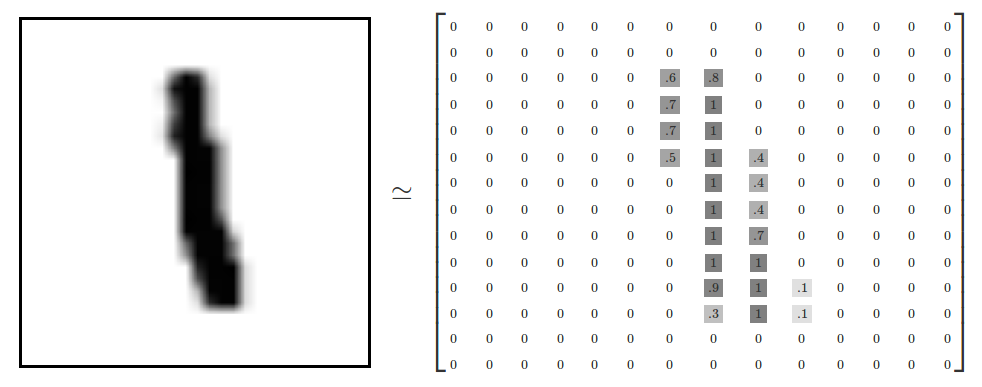

In [0]:
from IPython.display import Image
Image('https://i.stack.imgur.com/gC1x7.png', width=500)

Benutze folgendes Template:

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        # Set hidden size, number of layers, lstm layer and linear output layer 
    
    def forward(self, x):
        # Set initial hidden and cell states ho and c0
        
        # Forward propagate LSTM
        # returns tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        return out

2. Benutze die Trainingsroutine aus den vorherigen Übungen.

## Fashion MNIST Dataset

In [0]:
import torch
from torchvision import datasets, transforms

batch_size = 64

# Konvertierung zu PyTorch Tensoren
transform = transforms.Compose([transforms.ToTensor()])

# Download und Laden des Trainingsdatensatzes (60k)
trainset = datasets.FashionMNIST('./FashionMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download und Laden des Validationsdatensatzes (10k)
validset = datasets.FashionMNIST('./FashionMNIST/', download=True, train=False, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

26427392it [00:04, 5809272.84it/s]                              


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 37451.46it/s]                           
0it [00:00, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


4423680it [00:02, 1711587.48it/s]                            
0it [00:00, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


8192it [00:00, 15310.66it/s]            

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!
